In [69]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import GPy
import deepgp

colours = ["#B35806", "#F1A340", "#FEE0B6", "#D8DAEB", "#998EC3", "#542788"]

In [3]:
GPy.util.datasets.authorize_download = lambda x: True

these_digits = [0, 1, 2, 6, 7, 9]
data = GPy.util.datasets.decampos_digits(which_digits=these_digits)


print("\nData keys:")
print(data.keys())

print("\nCitation:")
print(data['citation'])

print("\nInfo:")
print(data['info'])


characters.npy


[=======                       ]   1.344/5.586MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

[==============                ]   2.680/5.586MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

[=====================         ]   4.016/5.586MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

[============================  ]   5.352/5.586MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

[==============================]   5.586/5.586MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

[==============================]   1.074/1.074MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

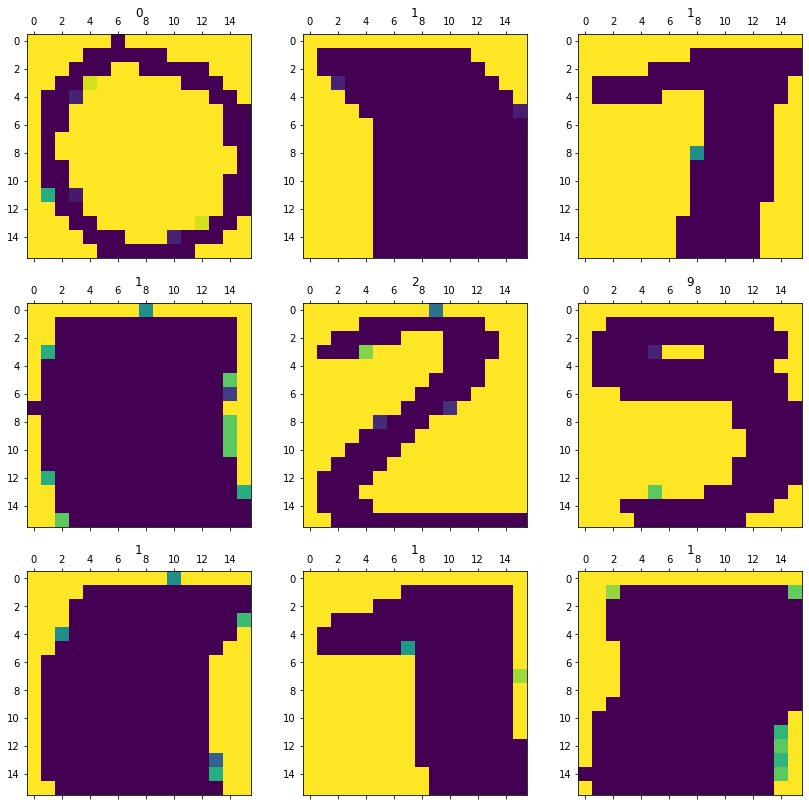

In [15]:
y = data['Y']
labels = data['str_lbls'].flatten()

f, axs = plt.subplots(3,3,figsize=(14,14))
for i,k in enumerate(np.random.randint(0, y.shape[0]-1, size=(9,1))):
    axs.ravel()[i].matshow(np.reshape(y[k,:],(16,16)))
    axs.ravel()[i].set_title(*labels[k])

## PCA

In [17]:
pca = GPy.util.pca.PCA

p = pca(y)

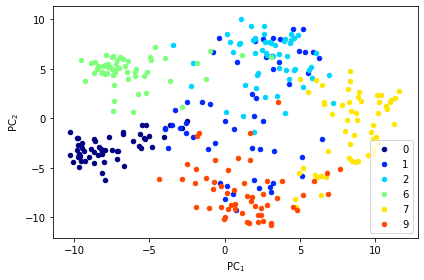

In [22]:
p.plot_2d(y, labels=labels);
plt.legend()

In [26]:
?pca

<BarContainer object of 20 artists>

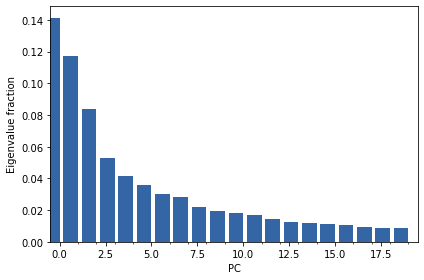

In [43]:
p.plot_fracs(20)

In [67]:
def plot_eigvals(p,n):
    ev = np.sort(p.eigvals/np.sum(p.eigvals))[::-1]
    plt.bar(np.arange(n),ev[:n])

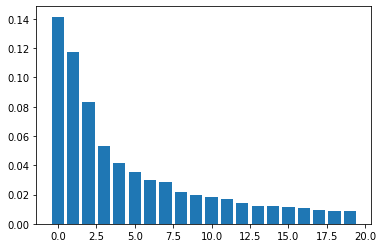

In [68]:
plot_eigvals(p,20)

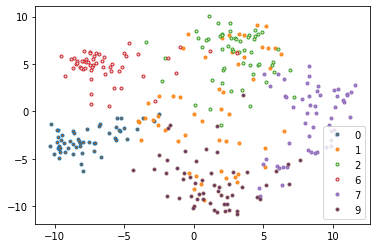

In [85]:
for i, digit in enumerate(these_digits):
    values = y[np.where(labels == str(digit))]
    plt.plot(*p.project(values, 2).T, '.', mfc = colours[i], label=digit)
plt.legend()

### GP LVM

In [86]:
k = GPy.kern.Linear(4, ARD=True)

m = GPy.models.GPLVM(y, input_dim=4, kernel=k)

m.optimize(messages=1, max_iters=1000)

index,GPLVM.linear.variances,constraints,priors
[0],0.02328422,+ve,
[1],0.02578430,+ve,
[2],0.01867931,+ve,
[3],0.00524552,+ve,


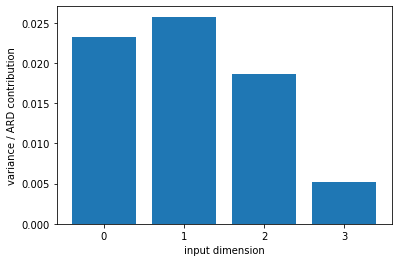

In [108]:
display(m.kern.variances)
plt.bar(np.arange(4),m.kern.variances.values)
plt.ylabel("variance / ARD contribution")
plt.xlabel("input dimension")
plt.xticks(np.arange(4));

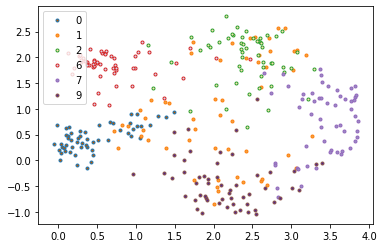

In [117]:
X = m.X[:,np.argsort(m.kern.variances)[-2:]]
for i, digit in enumerate(these_digits):
    values = X[np.where(labels==str(digit))]
    plt.plot(*values.T, '.', mfc=colours[i], label=digit)
plt.legend()

### Exercise

Plot your own with a different kernel

## Unsupervised Learning with Deep GPs

In [120]:
num_hidden = 2
latent_dim = [5, 4]

kern_bias_rbf = lambda dim: GPy.kern.RBF(dim, ARD=True) + GPy.kern.Bias(dim)

m_deep = deepgp.DeepGP(
    [y.shape[1], *latent_dim], # not there is no X shape as it is latent
    Y=y,
    inits=['PCA']*num_hidden,
    kernels=[kern_bias_rbf(dim) for dim in latent_dim],
    num_inducing = 40,
    back_constraint = False
)

In [121]:
def optimise_dgp(model, messages=True):
    ''' Utility function for optimising deep GP by first
        reinitiailising the Gaussian noise at each layer
        (for reasons pertaining to stability)
    '''
    model.initialize_parameter()
    for i,layer in enumerate(model.layers):
        layer.likelihood.variance.constrain_positive(warning=False)
        output_var = layer.Y.var() if i == 0 else layer.Y.mean.var()
        layer.likelihood.variance = output_var*0.1 # small variance may cause collapse
    model.optimize(messages=messages, max_iters=10000)

In [122]:
optimise_dgp(m_deep)

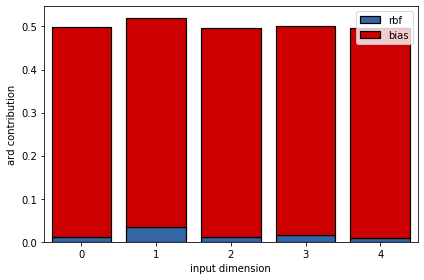

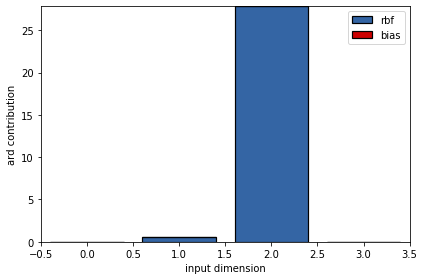

In [139]:
[(layer.kern.plot_ARD(), plt.legend()) for layer in m_deep.layers];

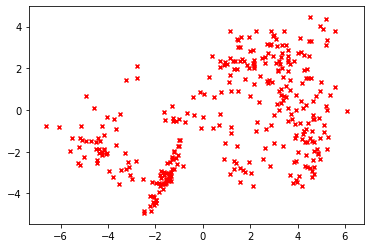

In [143]:
deepgp.util.visualize_DGP(m_deep, y.argmax(axis=1), layer=0, dims=[1,2])

In [169]:
?m_deep.layer_1.kern.input_sensitivity

<BarContainer object of 4 artists>

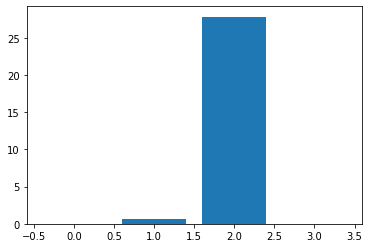

In [166]:
plt.bar([0,1,2,3],m_deep.layers[-1].kern.input_sensitivity())

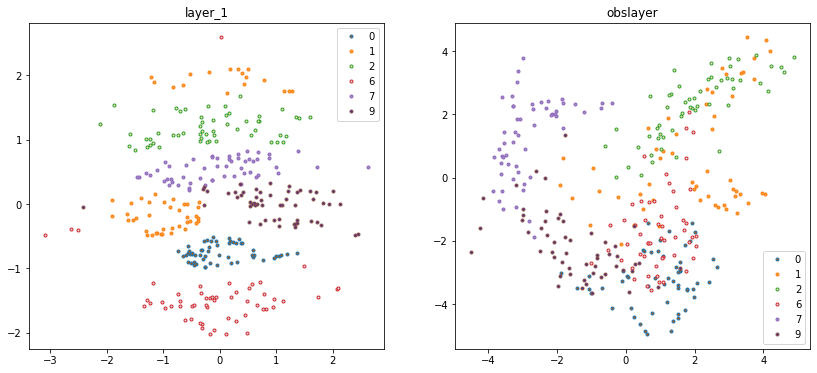

In [174]:
_, axs = plt.subplots(1,2, figsize=(14,6))

for k, layer in enumerate(reversed(m_deep.layers)):
    X = layer.X.mean.values[:,np.argsort(layer.kern.input_sensitivity())[-2:]]
    for i, digit in enumerate(these_digits):
        values = X[np.where(labels==str(digit))]
        axs[k].plot(*values.T, '.', mfc=colours[i], label=digit)
    axs[k].legend()
    axs[k].set_title(layer.name)
    

In [192]:
lx = np.linspace(-3.5, 3.5, num=50)
x1 = np.vstack(zip(*[(xi,xj) for xi in lx for xj in lx]))


#m_deep.layer_1.predict()

In [220]:
m_deep.X

latent_space.,value,constraints,priors
mean,"(330, 4)",,
variance,"(330, 4)",+ve,


TypeError: calculated free_dims [0 1 2 3] from visible_dims None and fixed_dims [] is neither 1D nor 2D

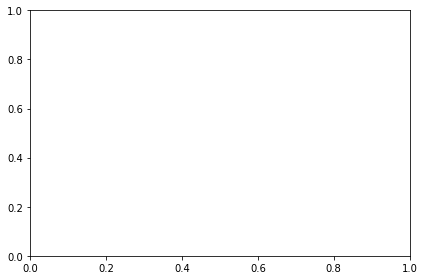